# Importing Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from math import ceil

# Reading data

In [2]:
files_list = os.listdir('../data')
target_file_name = 'profile.txt'
sensors_list = [file.split('.txt')[0] for file in files_list if file != target_file_name]

In [3]:
target = pd.read_csv(f'../data/{target_file_name}', delimiter='\t', header=None)[3] # 3 is reference to the Hydraulic accumulator

In [4]:
experiment_time_seconds = 60
sensors_data_dict_freq = {}
sensors_names_dict_freq = {}
for sensor in sensors_list:
    df_sensor = pd.read_csv(f'../data/{sensor}.txt', delimiter='\t', header=None)
    n_samples = df_sensor.shape[1]
    freq = n_samples/experiment_time_seconds
    if freq not in sensors_data_dict_freq:
        sensors_data_dict_freq[freq]=df_sensor
        sensors_names_dict_freq[freq]=[sensor]
    else:
        sensors_data_dict_freq[freq]=np.dstack((sensors_data_dict_freq[freq], df_sensor))
        sensors_names_dict_freq[freq]+=[sensor]


In [5]:
for freq, names_list in sensors_names_dict_freq.items():
    n_sensors = len(names_list)
    print(f'There are {n_sensors} sensors with the frequency of {int(freq)} Hz.')

There are 8 sensors with the frequency of 1 Hz.
There are 7 sensors with the frequency of 100 Hz.
There are 2 sensors with the frequency of 10 Hz.


In [6]:
one_hz_data = sensors_data_dict_freq[1]
one_hz_names = sensors_names_dict_freq[1]

ten_hz_data = sensors_data_dict_freq[10]
ten_hz_names = sensors_names_dict_freq[10]

hund_hz_data = sensors_data_dict_freq[100]
hund_hz_names = sensors_names_dict_freq[100]

In [7]:
for freq, data in sensors_data_dict_freq.items():
    print(f'{int(freq)} Hz sensors data shape: {data.shape}')

1 Hz sensors data shape: (2205, 60, 8)
100 Hz sensors data shape: (2205, 6000, 7)
10 Hz sensors data shape: (2205, 600, 2)


# Exploratory Data Analysis

According to the documentation the representation of the target values is:

- Hydraulic accumulator / bar: \
      - 130: optimal pressure (599 instances) \
      - 115: slightly reduced pressure (399 instances) \
      - 100: severely reduced pressure (399 instances) \
      - 90: close to total failure (808 instances)

For easier interpretability I will assume:

- Hydraulic accumulator / bar: \
      - 0: optimal pressure (599 instances) \
      - 1: slightly reduced pressure (399 instances) \
      - 2: severely reduced pressure (399 instances) \
      - 3: close to total failure (808 instances)

In [8]:
rename_target = {
    130:0,
    115:1,
    100:2,
    90:3
}

In [9]:
rename_target = {
    130:0,
    115:1,
    100:2,
    90:3
}
target = target.map(rename_target)

In [10]:
df_count = pd.DataFrame({'condition':target.value_counts().index, 'count':target.value_counts().values})
df_count = df_count.sort_values(by='condition').reset_index(drop=True)
df_count

condition  count
0          0    599
1          1    399
2          2    399
3          3    808

We can see that we don't have a big difference beetween the conditions of the experiments 

Checking any missing value

In [11]:
def check_missing_values(data:np.ndarray, names:list) -> None:    
    nan_values_sensors = sum(np.isnan(data))
    n_samples_sensor = data.shape[0]*data.shape[1]
    for sensor_idx in range(nan_values_sensors.shape[1]):
        nan_values_sensor = sum(nan_values_sensors[:,sensor_idx])
        nan_values_perc = round(100*nan_values_sensor/n_samples_sensor,2)
        print(f'The sensor {names[sensor_idx]} has {nan_values_perc} % of missing values.')

In [12]:
check_missing_values(one_hz_data, one_hz_names)
check_missing_values(ten_hz_data, ten_hz_names)
check_missing_values(hund_hz_data, hund_hz_names)

The sensor CE has 0.0 % of missing values.
The sensor CP has 0.0 % of missing values.
The sensor SE has 0.0 % of missing values.
The sensor TS1 has 0.0 % of missing values.
The sensor TS2 has 0.0 % of missing values.
The sensor TS3 has 0.0 % of missing values.
The sensor TS4 has 0.0 % of missing values.
The sensor VS1 has 0.0 % of missing values.
The sensor FS1 has 0.0 % of missing values.
The sensor FS2 has 0.0 % of missing values.


The sensor EPS1 has 0.0 % of missing values.
The sensor PS1 has 0.0 % of missing values.
The sensor PS2 has 0.0 % of missing values.
The sensor PS3 has 0.0 % of missing values.
The sensor PS4 has 0.0 % of missing values.
The sensor PS5 has 0.0 % of missing values.
The sensor PS6 has 0.0 % of missing values.


Data visualization

In [13]:
target_color_dict = {
    0:'green',
    1:'gold',
    2:'orange',
    3:'red'
}

In [14]:
def plot_experiment_behavior(data, names, experiment_idx):
    n_cols = 2
    n_sensors = data.shape[2]
    n_rows = ceil(n_sensors/n_cols)
    condition = target[experiment_idx]
    freq = int(data.shape[1]/60)
    fig = plt.figure(figsize=(12, 3*n_rows))
    for sensor_idx in range(n_sensors):
        ax = plt.subplot(n_rows,n_cols,sensor_idx+1)
        ax.plot(data[experiment_idx,:,sensor_idx], label=condition, color=target_color_dict[condition])
        ax.set_title(names[sensor_idx])
        ax.grid()
        ax.legend()
        ax.set_xlabel('Samples')
    fig.suptitle(f'{freq} Hz sensors behavior', fontsize=18)
    plt.tight_layout()
    plt.show()

In [15]:
def random_experiment_by_condition(target:pd.Series, condition:int) -> int:
    target_by_condition = target[target==condition].index
    return np.random.choice(target_by_condition)

In [16]:
random_experiment_idx = np.random.choice(target.index)
random_experiment_idx = random_experiment_by_condition(target, 0)

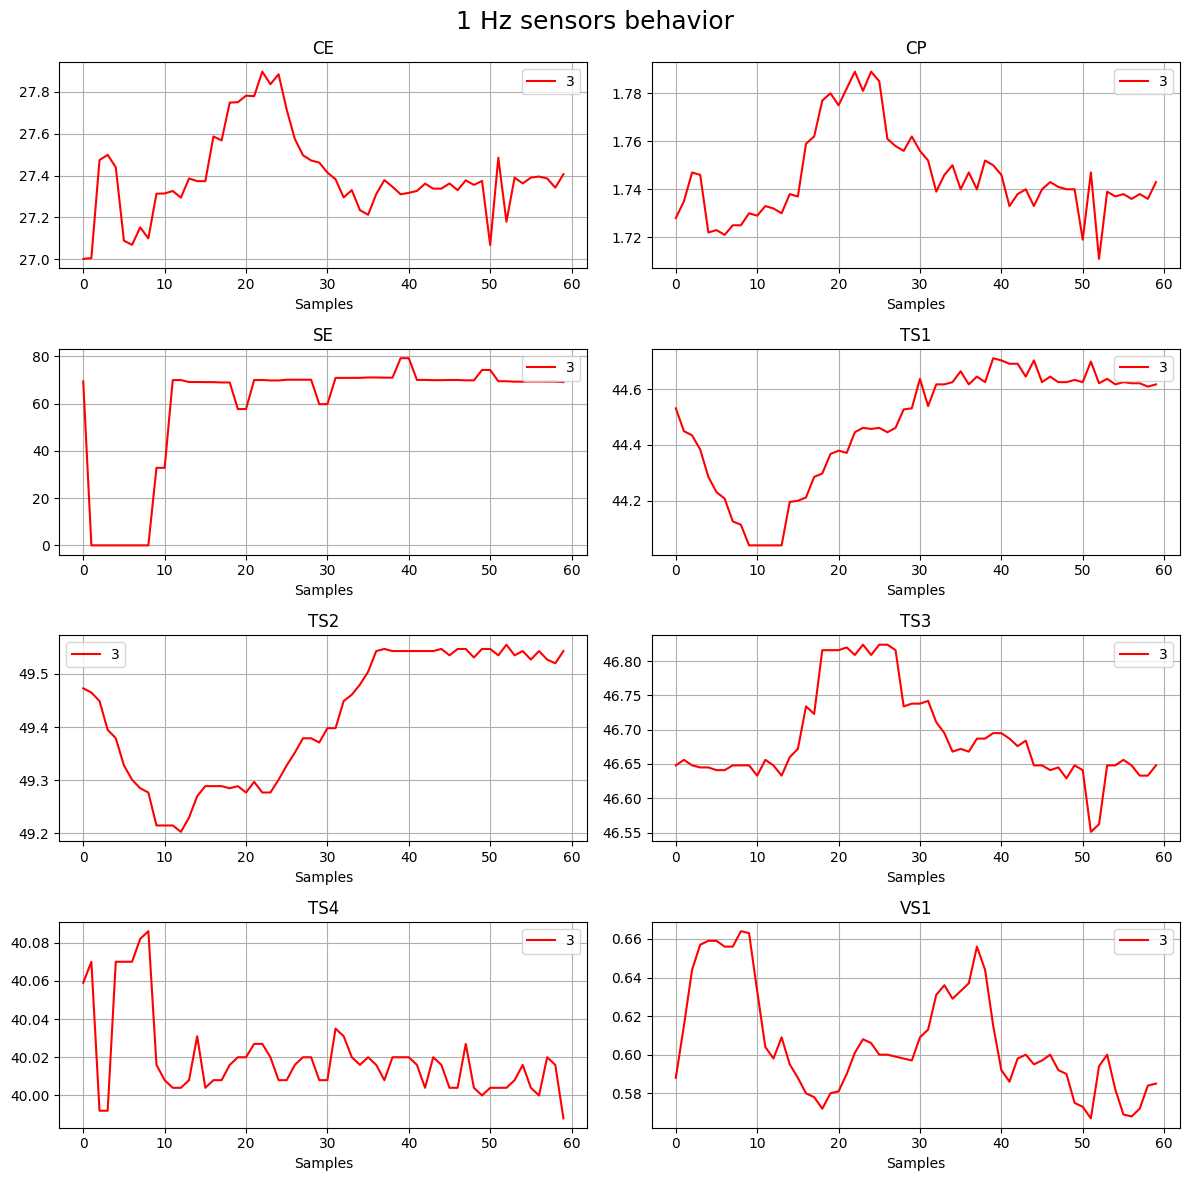

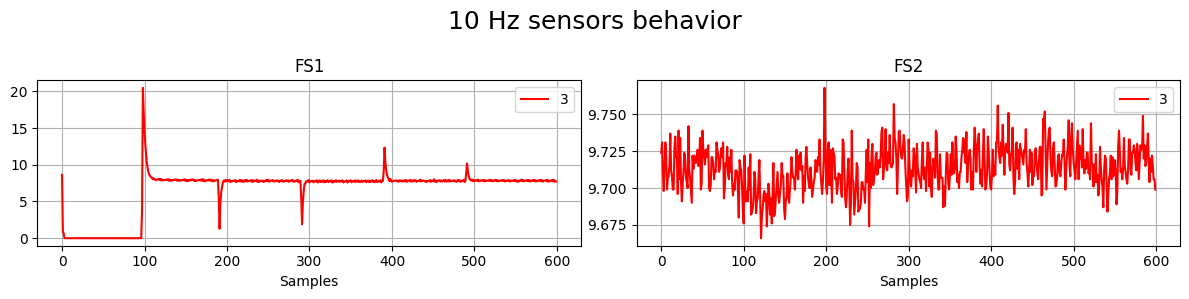

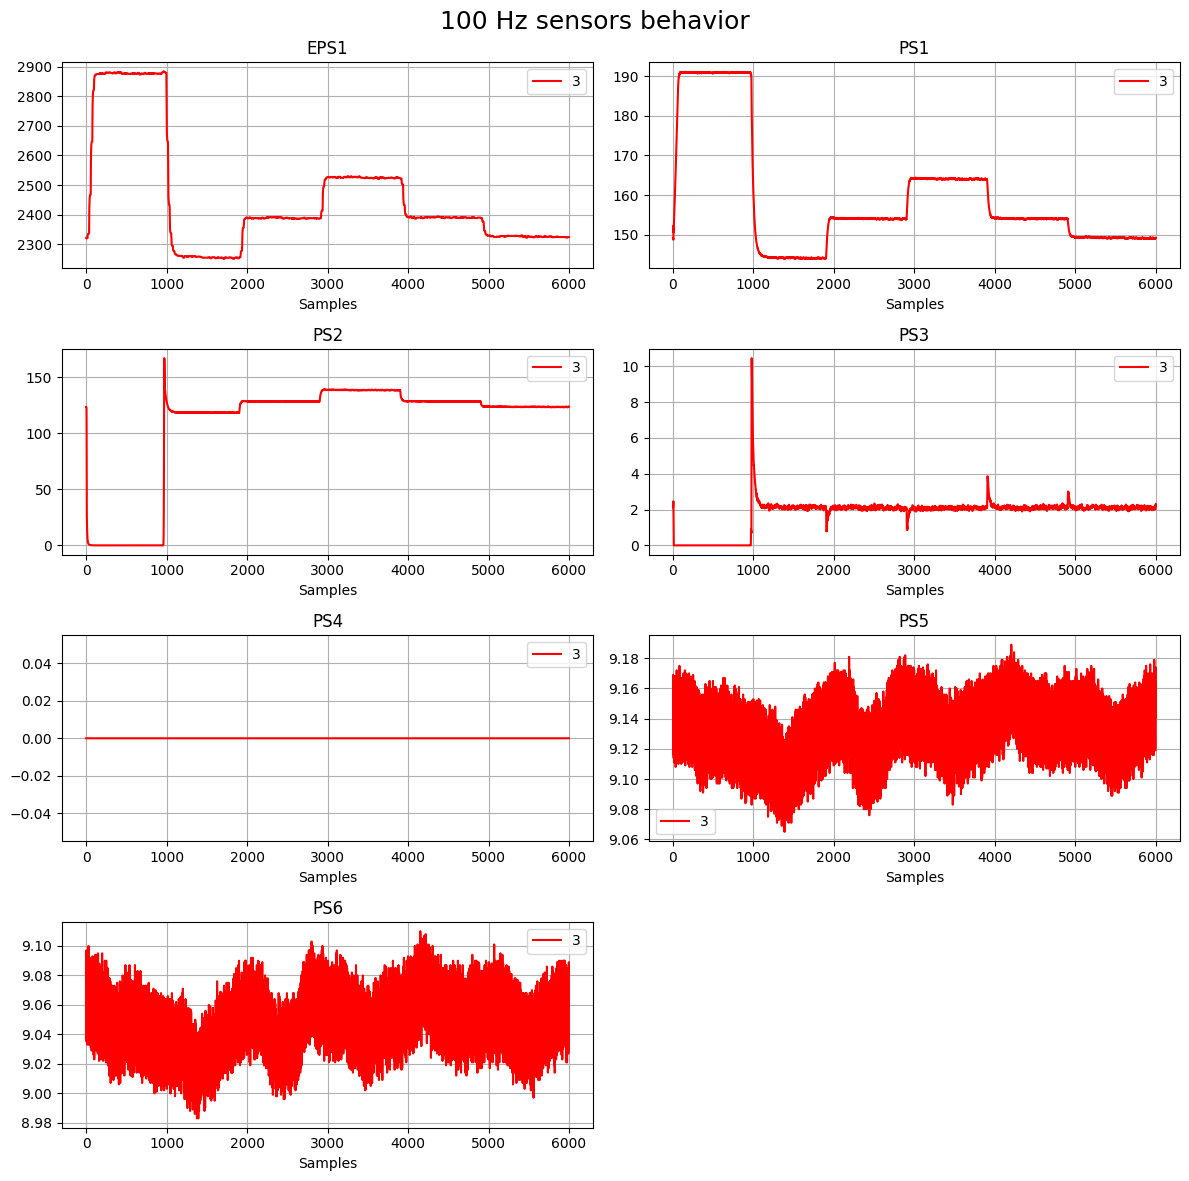

In [17]:
random_experiment_idx = np.random.choice(target.index)
plot_experiment_behavior(one_hz_data, one_hz_names, random_experiment_idx)
plot_experiment_behavior(ten_hz_data, ten_hz_names, random_experiment_idx)
plot_experiment_behavior(hund_hz_data, hund_hz_names, random_experiment_idx)

Check if any sensor has constant value for many experiments.

In [18]:
def calculate_percentage_constant_values(data, names, std_multiplier=1):
    idx_exp_constant_values_sensors = []
    for sensor_idx in range(data.shape[2]):
        n_experiments = data.shape[0]
        samples = data.shape[1]
        sensor_data = data[:,:,sensor_idx]
        # Calculate mean and standard deviation for each experiment
        mean_values = np.mean(sensor_data, axis=1)
        std_values = np.std(sensor_data, axis=1)

        count = 0
        idx_exp_constant_values=[]
        for exp in range(n_experiments):
            
            # Define upper and lower limits for constant values
            upper_limit = mean_values[exp] + std_multiplier * std_values[exp]
            lower_limit = mean_values[exp] - std_multiplier * std_values[exp]
            # Calculate percentage of constant values for the current experiment
            perc_constant_values = 100 * np.sum((sensor_data[exp] >= lower_limit) & (sensor_data[exp] <= upper_limit)) / samples
            # Check if all values in the current experiment are constant
            if perc_constant_values == 100:
                count += 1
                idx_exp_constant_values.append(exp)
        idx_exp_constant_values_sensors.append(idx_exp_constant_values)
                
        # Calculate the percentage of experiments without oscillation for the current sensor
        percentage = round(100*count / n_experiments, 2)
        print(f'The sensor {names[sensor_idx]} has {percentage} % of experiments without oscillation')
    
    return idx_exp_constant_values_sensors

In [19]:
_ = calculate_percentage_constant_values(one_hz_data, one_hz_names)
_ = calculate_percentage_constant_values(ten_hz_data, ten_hz_names)
_ = calculate_percentage_constant_values(hund_hz_data, hund_hz_names)

The sensor CE has 0.0 % of experiments without oscillation
The sensor CP has 0.0 % of experiments without oscillation
The sensor SE has 0.0 % of experiments without oscillation
The sensor TS1 has 0.0 % of experiments without oscillation
The sensor TS2 has 0.0 % of experiments without oscillation
The sensor TS3 has 0.0 % of experiments without oscillation
The sensor TS4 has 0.0 % of experiments without oscillation
The sensor VS1 has 0.0 % of experiments without oscillation
The sensor FS1 has 0.0 % of experiments without oscillation
The sensor FS2 has 0.0 % of experiments without oscillation
The sensor EPS1 has 0.0 % of experiments without oscillation
The sensor PS1 has 0.0 % of experiments without oscillation
The sensor PS2 has 0.0 % of experiments without oscillation
The sensor PS3 has 0.0 % of experiments without oscillation
The sensor PS4 has 56.15 % of experiments without oscillation
The sensor PS5 has 0.0 % of experiments without oscillation
The sensor PS6 has 0.0 % of experiments 

As we can see, the sensor PS4 has no oscilation in most of the experiments. Lets se if we can remove this sensor from the analysis.

In [20]:
def plot_random_experiments_all_conditions(data, names, target):
    n_cols = 2
    n_sensors = data.shape[2]
    n_rows = ceil(n_sensors/n_cols)
    conditions = target.unique()
    
    freq = int(data.shape[1]/60)
    fig = plt.figure(figsize=(12, 3*n_rows))
    for sensor_idx in range(n_sensors):
        ax = plt.subplot(n_rows,n_cols,sensor_idx+1)
        for condition in conditions:
            experiment_idx = np.random.choice(target[target==condition].index)
            ax.plot(data[experiment_idx,:,sensor_idx], label=condition, color=target_color_dict[condition])
        
        ax.set_title(names[sensor_idx])
        ax.grid()
        ax.legend()
        ax.set_xlabel('Samples')
    fig.suptitle(f'{freq} Hz sensors behavior', fontsize=18)
    plt.tight_layout()
    plt.show()

In [21]:
# plot_random_experiments_all_conditions(one_hz_data, one_hz_names, target)
# plot_random_experiments_all_conditions(ten_hz_data, ten_hz_names, target)
# plot_random_experiments_all_conditions(hund_hz_data, hund_hz_names, target)

In [35]:
def plot_mean_behavior_all_conditions(data, names, target, n_cols=2):
    n_sensors = data.shape[2]
    n_rows = ceil(n_sensors/n_cols)
    conditions = target.unique()
    
    freq = int(data.shape[1]/60)
    fig = plt.figure(figsize=(12, 3*n_rows))
    for sensor_idx in range(n_sensors):
        ax = plt.subplot(n_rows,n_cols,sensor_idx+1)
        for condition in conditions:
            idxs_condition = target[target==condition].index
            mean = np.mean(data[idxs_condition,:,sensor_idx],axis=0)
            ax.plot(mean, label=condition, color=target_color_dict[condition])
        
        ax.set_title(names[sensor_idx])
        ax.grid()
        ax.legend()
        ax.set_xlabel('Samples')
    fig.suptitle(f'{freq} Hz mean behavior sensors', fontsize=18)
    plt.tight_layout()
    plt.show()

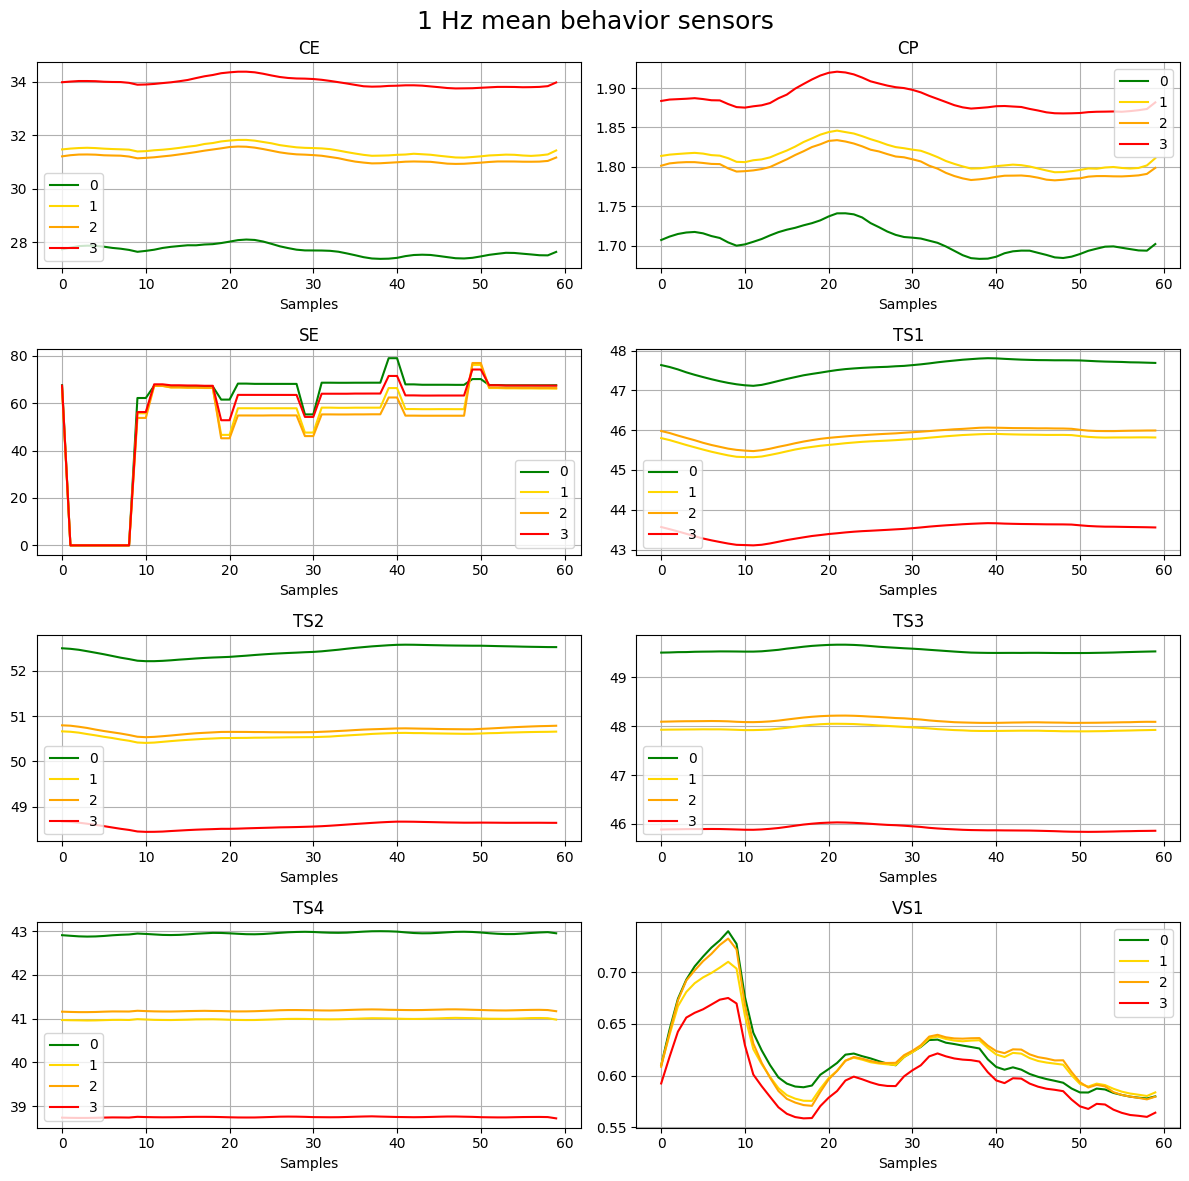

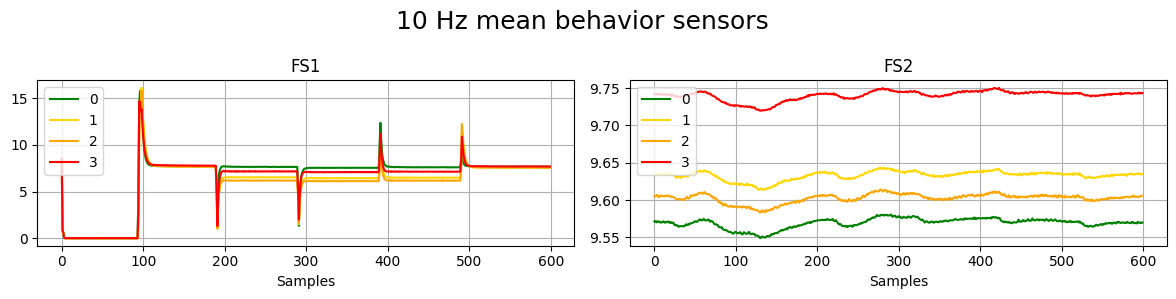

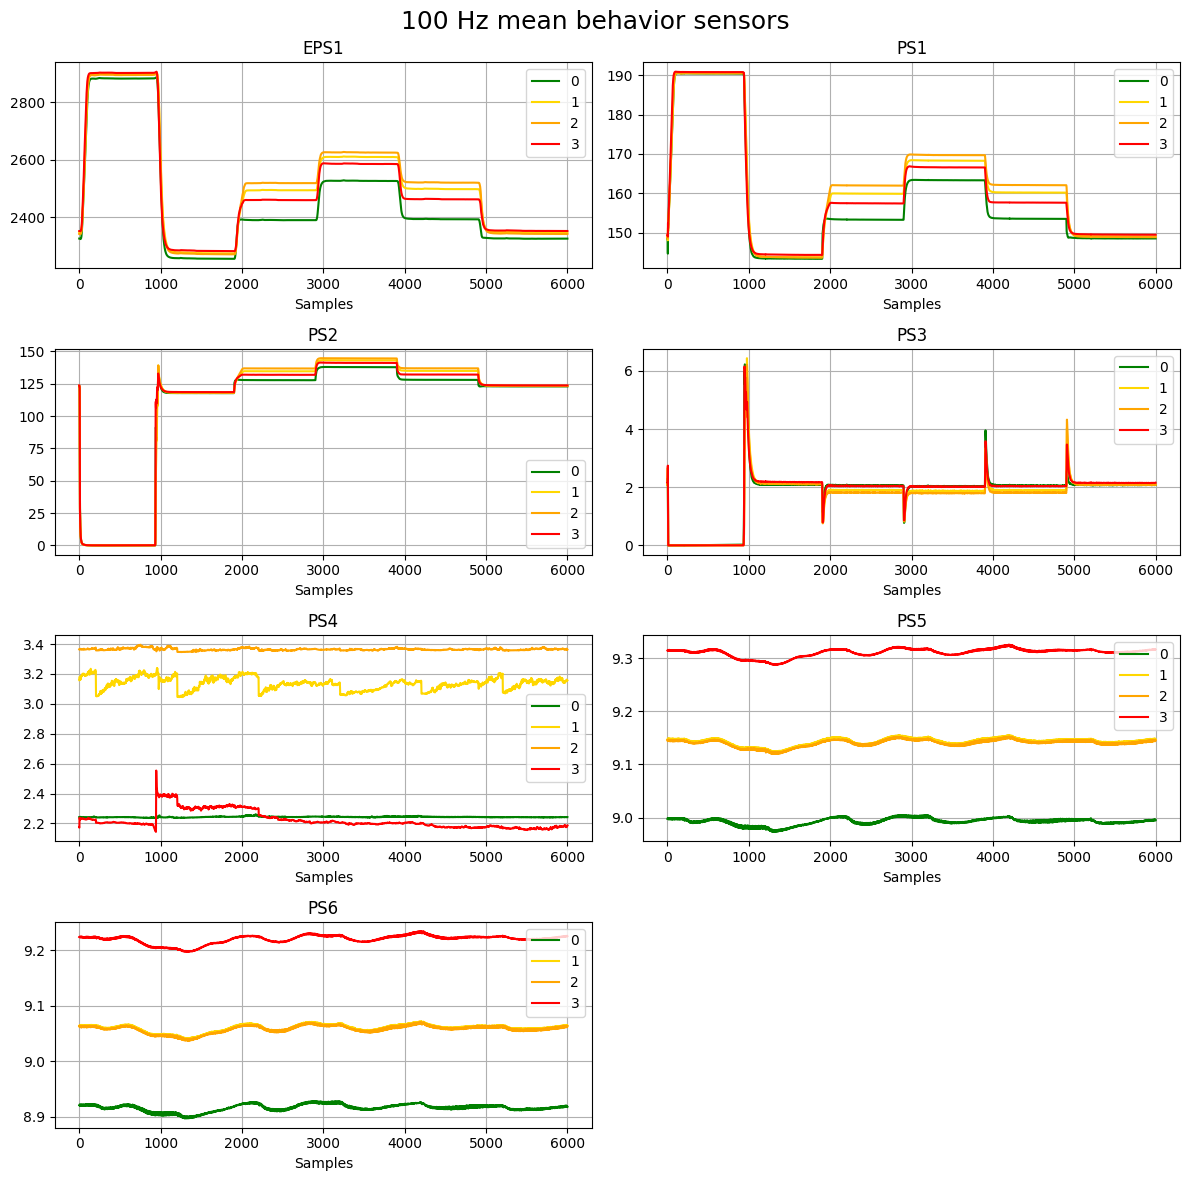

In [36]:
plot_mean_behavior_all_conditions(one_hz_data, one_hz_names, target)
plot_mean_behavior_all_conditions(ten_hz_data, ten_hz_names, target)
plot_mean_behavior_all_conditions(hund_hz_data, hund_hz_names, target)

The plots clearly show that the sensors behave differently depending on the experiment's conditions. Interestingly, conditions 1 and 2 seem to have similar effects on most sensors. So, it might be a good idea to dig deeper and explore other metrics instead of just looking at the average.

Althought the sensor PS4 has most experiments with no oscilation, the avarage behavior has a significant difference beetween the conditions of the experiments, so we CAN'T remove it from the analysis.

## Feature engineering

In [24]:
features_dict = {
    'mean': lambda x:np.mean(x, axis=1),
    'median': lambda x:np.median(x, axis=1),
    'std': lambda x:np.std(x, axis=1),
    'max': lambda x:np.max(x, axis=1),
    'min': lambda x:np.min(x, axis=1),
}

In [25]:
def create_features_df(data, names, features_dict):
    n_sensors = data.shape[2]
    df = pd.DataFrame()
    for sensor_idx in range(n_sensors):
        sensor_name = names[sensor_idx]
        sensor_data = data[:,:,sensor_idx]
        for feat_name, feat in features_dict.items():
            column_name = sensor_name + '_' + feat_name
            column_values = feat(sensor_data)
            df[column_name] = column_values

    return df

In [26]:
one_hz_df = create_features_df(
    one_hz_data,
    one_hz_names,
    features_dict
)

ten_hz_df = create_features_df(
    ten_hz_data,
    ten_hz_names,
    features_dict
)

hund_hz_df = create_features_df(
    hund_hz_data,
    hund_hz_names,
    features_dict
)

In [27]:
df = pd.concat([one_hz_df, ten_hz_df, hund_hz_df], axis=1)

In [28]:
df['target'] = target

In [29]:
df

CE_mean  CE_median    CE_std  CE_max  CE_min   CP_mean  CP_median  \
0     39.601350    40.6755  6.317224  47.438  28.866  1.862750     1.9240   
1     25.786433    25.3855  1.672019  29.208  23.320  1.255550     1.2340   
2     22.218233    22.1040  0.633003  23.554  21.220  1.113217     1.1095   
3     20.459817    20.4805  0.451941  21.565  19.673  1.062150     1.0660   
4     19.787017    19.7985  0.287728  20.460  19.133  1.070467     1.0725   
...         ...        ...       ...     ...     ...       ...        ...   
2200  46.628517    46.6335  0.235783  47.092  46.242  2.160600     2.1615   
2201  46.689817    46.6510  0.389641  47.486  45.762  2.151450     2.1485   
2202  46.472300    46.7005  0.458639  47.206  45.683  2.143300     2.1425   
2203  46.544967    46.5490  0.240175  47.001  45.846  2.148483     2.1480   
2204  46.647933    46.6035  0.248020  47.109  46.144  2.157050     2.1495   

        CP_std  CP_max  CP_min  ...  PS5_median   PS5_std  PS5_max  PS5_min  \
0     0.277047   2.188   1.383  ...       9.844  0.088147   10.016    9.681   
1     0.073981   1.414   1.147  ...       9.632  0.038389    9.745    9.557   
2     0.023069   1.159   1.076  ...       9.528  0.035814    9.640    9.455   
3     0.024415   1.107   1.022  ...       9.436  0.037065    9.535    9.363   
4     0.021297   1.106   1.016  ...       9.358  0.029777    9.443    9.290   
...        ...     ...     ...  ...         ...       ...      ...      ...   
2200  0.018019   2.196   2.127  ...       9.970  0.022275   10.028    9.910   
2201  0.023176   2.200   2.094  ...       9.965  0.022021   10.014    9.901   
2202  0.026955   2.188   2.099  ...       9.964  0.022525   10.019    9.898   
2203  0.017628   2.188   2.107  ...       9.967  0.023515   10.022    9.898   
2204  0.020863   2.194   2.126  ...       9.972  0.023192   10.024    9.903   

      PS6_mean  PS6_median   PS6_std  PS6_max  PS6_min  target  
0     9.728097       9.733  0.085359    9.887    9.568       0  
1     9.529488       9.526  0.036313    9.637    9.454       0  
2     9.427949       9.425  0.036028    9.536    9.348       0  
3     9.337430       9.335  0.037372    9.431    9.257       0  
4     9.260636       9.260  0.028590    9.342    9.195       0  
...        ...         ...       ...      ...      ...     ...  
2200  9.850361       9.849  0.021800    9.905    9.790       3  
2201  9.844854       9.844  0.021930    9.894    9.777       3  
2202  9.842628       9.842  0.022092    9.896    9.777       3  
2203  9.846690       9.846  0.023183    9.900    9.767       3  
2204  9.851949       9.851  0.022550    9.900    9.785       3  

[2205 rows x 86 columns]

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 86 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CE_mean      2205 non-null   float64
 1   CE_median    2205 non-null   float64
 2   CE_std       2205 non-null   float64
 3   CE_max       2205 non-null   float64
 4   CE_min       2205 non-null   float64
 5   CP_mean      2205 non-null   float64
 6   CP_median    2205 non-null   float64
 7   CP_std       2205 non-null   float64
 8   CP_max       2205 non-null   float64
 9   CP_min       2205 non-null   float64
 10  SE_mean      2205 non-null   float64
 11  SE_median    2205 non-null   float64
 12  SE_std       2205 non-null   float64
 13  SE_max       2205 non-null   float64
 14  SE_min       2205 non-null   float64
 15  TS1_mean     2205 non-null   float64
 16  TS1_median   2205 non-null   float64
 17  TS1_std      2205 non-null   float64
 18  TS1_max      2205 non-null   float64
 19  TS1_mi

In [123]:
df.describe()

CE_mean    CE_median       CE_std       CE_max       CE_min  \
count  2205.000000  2205.000000  2205.000000  2205.000000  2205.000000   
mean     31.299077    31.287446     0.284921    31.880312    30.785665   
std      11.575330    11.570829     0.198089    11.602740    11.583481   
min      17.555983    17.501000     0.062636    18.142000    17.042000   
25%      20.084650    20.083000     0.215544    20.694000    19.513000   
50%      27.392533    27.363500     0.261915    27.983000    26.862000   
75%      46.677383    46.648500     0.326925    47.272000    46.168000   
max      47.903667    47.945000     6.317224    48.777000    47.626000   

           CP_mean    CP_median       CP_std       CP_max       CP_min  ...  \
count  2205.000000  2205.000000  2205.000000  2205.000000  2205.000000  ...   
mean      1.808399     1.806442     0.022502     1.855768     1.769092  ...   
std       0.278263     0.277476     0.011044     0.278504     0.282245  ...   
min       1.062150     1.066000     0.006856     1.105000     1.016000  ...   
25%       1.550100     1.550000     0.018223     1.604000     1.502000  ...   
50%       1.739683     1.737000     0.021292     1.786000     1.701000  ...   
75%       2.148483     2.145000     0.024886     2.190000     2.115000  ...   
max       2.840100     2.843000     0.340648     2.909000     2.768000  ...   

        PS5_median      PS5_std      PS5_max      PS5_min     PS6_mean  \
count  2205.000000  2205.000000  2205.000000  2205.000000  2205.000000   
mean      9.162750     0.022251     9.217760     9.103272     9.079363   
std       0.576128     0.002095     0.574336     0.572561     0.549589   
min       8.366000     0.020140     8.418000     8.318000     8.321527   
25%       8.547000     0.021630     8.608000     8.491000     8.487167   
50%       9.116000     0.022041     9.172000     9.054000     9.031516   
75%       9.844000     0.022567     9.894000     9.783000     9.729275   
max       9.977000     0.088147    10.041000     9.915000     9.856591   

        PS6_median      PS6_std      PS6_max      PS6_min       target  
count  2205.000000  2205.000000  2205.000000  2205.000000  2205.000000  
mean      9.078779     0.022449     9.134722     9.017797     1.642177  
std       0.549500     0.002104     0.547494     0.545082     1.227461  
min       8.321000     0.020163     8.374000     8.268000     0.000000  
25%       8.487000     0.021623     8.550000     8.428000     0.000000  
50%       9.031000     0.022115     9.090000     8.969000     2.000000  
75%       9.729000     0.022897     9.779000     9.663000     3.000000  
max       9.856000     0.085359     9.910000     9.790000     3.000000  

[8 rows x 86 columns]

In [119]:
def plot_distribution_by_condition(df, target_col, n_cols=4):
        
    n_rows = int(ceil(df.shape[1]/n_cols))
    palette = list(target_color_dict.values())
    fig = plt.figure(figsize=(18, n_rows*4))
    for idx, column in enumerate(df.columns):
        if column != target_col:
            ax = plt.subplot(n_rows, n_cols, idx+1)
            sns.kdeplot(data=df, x=column, hue=target_col, palette=palette, ax=ax)
            ax.set_title(column)
            ax.grid()
        
    fig.tight_layout()
    plt.show()

C:\Users\anton\AppData\Local\Temp\ipykernel_20936\1409942181.py:9: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\anton\AppData\Local\Temp\ipykernel_20936\1409942181.py:9: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\anton\AppData\Local\Temp\ipykernel_20936\1409942181.py:9: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\anton\AppData\Local\Temp\ipykernel_20936\1409942181.py:9: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



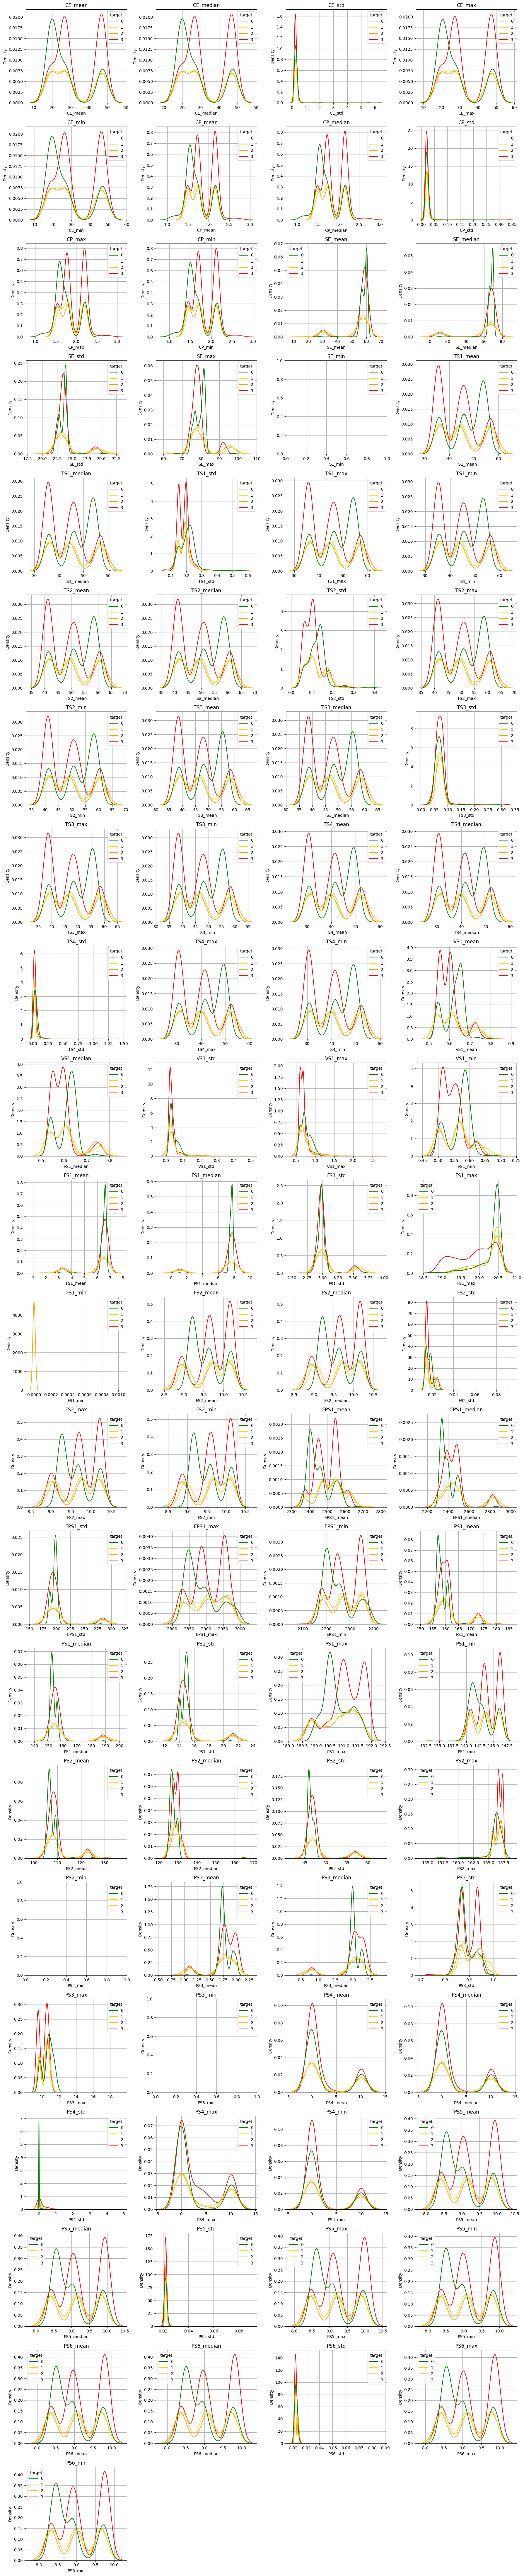

In [120]:
plot_distribution_by_condition(df, 'target')

In [126]:
def scatter_plot(df, target_col, n_cols=4):
        
    n_rows = int(ceil(df.shape[1]/n_cols))
    palette = list(target_color_dict.values())
    fig = plt.figure(figsize=(18, n_rows*4))
    for idx, column in enumerate(df.columns):
        if column != target_col:
            ax = plt.subplot(n_rows, n_cols, idx+1)
            sns.scatterplot(data=df, x=column, y=target_col, ax=ax)
            ax.set_title(column)
            ax.grid()
        
    fig.tight_layout()
    plt.show()

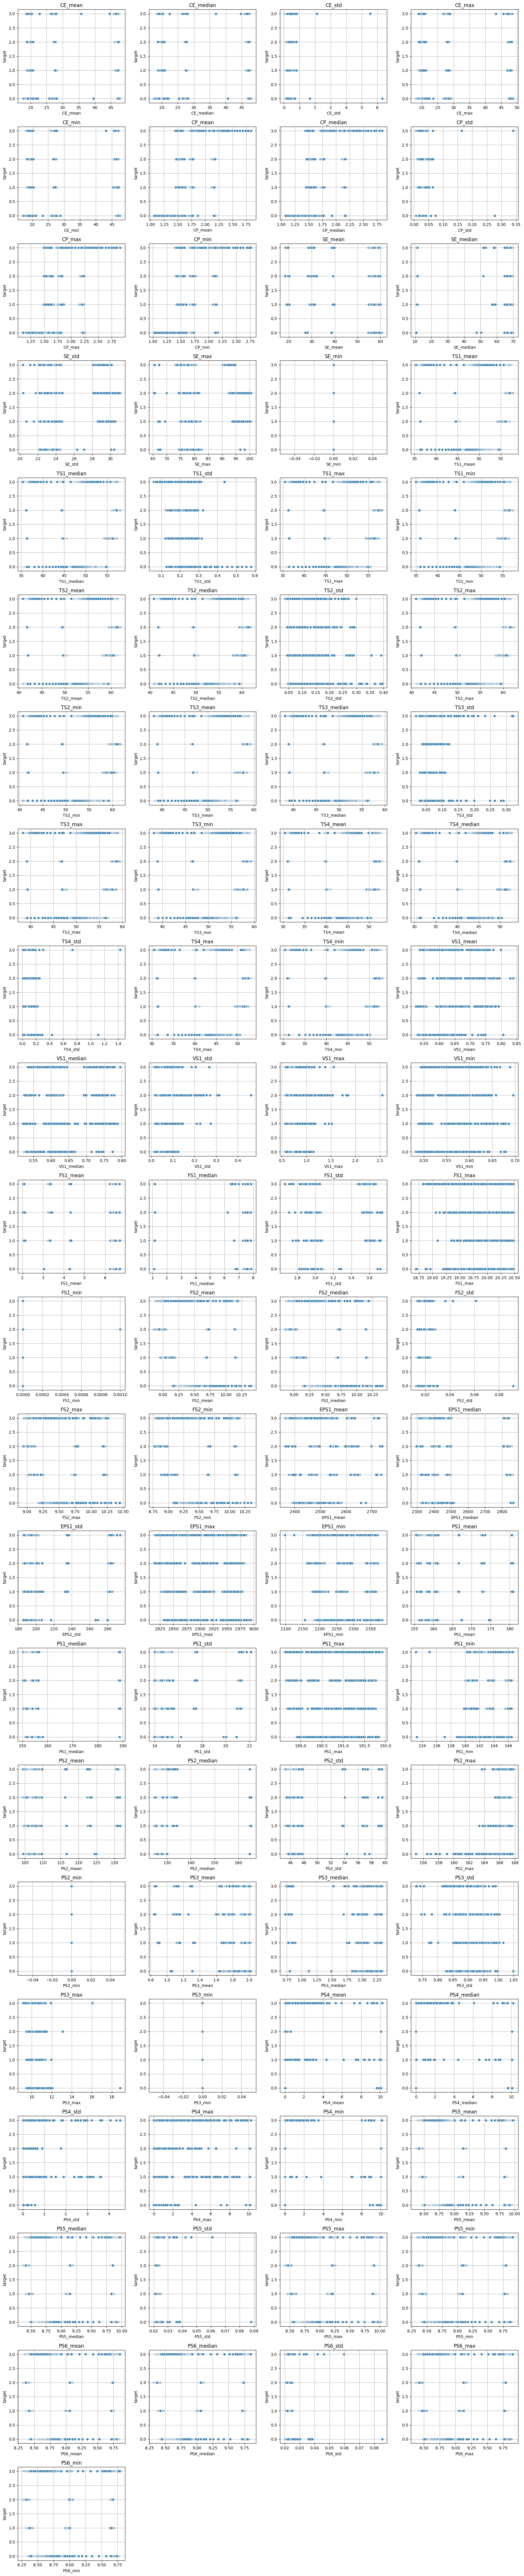

In [127]:
scatter_plot(df, 'target')